In [24]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
print(tf.__version__)

2.1.0


In [25]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0],'GPU')# 设定只第一个GPU是可见的
tf.config.experimental.set_virtual_device_configuration(# 给GPU做逻辑切分
                gpus[0],# 制定使用哪个gpu
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),
                tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),
                tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),
                tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3072),]
        )
print(len(gpus))
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(logical_gpus))



1
4


In [26]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [27]:
print(PATH)

/home/zo1zu22/.keras/datasets/cats_and_dogs_filtered


In [28]:
train_dir = os.path.join(PATH, 'train')
valid_dir = os.path.join(PATH, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

In [29]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_va = len(os.listdir(valid_cats_dir))
num_dogs_va = len(os.listdir(valid_dogs_dir))
total_train = num_cats_tr + num_dogs_tr
total_valid = num_cats_va + num_dogs_va
print(num_cats_tr, num_dogs_tr, num_cats_va, num_dogs_va, total_train, total_valid)

1000 1000 500 500 2000 1000


In [30]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

# 资料准备
## 在将图像馈送到网络之前，将图像格式化为经过适当预处理的浮点张量：

### 1、从磁盘读取图像。
### 2、解码这些图像的内容，并根据其RGB内容将其转换为正确的网格格式。
### 3、将它们转换为浮点张量。
### 4、将张量从0到255之间的值重新缩放为0到1之间的值，因为神经网络更喜欢处理较小的输入值。
### *幸运的是，所有这些任务都可以通过提供的ImageDataGenerator类来完成tf.keras。它可以从磁盘读取图像并将其预处理为适当的张量。它还将设置将这些图像转换成张量的生成器，这对于训练网络很有帮助。

In [31]:
# 初始化生成器
train_image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
# 在定义用于训练和验证图像的生成器之后，
# 该flow_from_directory方法从磁盘加载图像，应用重新缩放，然后将图像调整为所需的尺寸。
train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size,
                                                                                      directory = train_dir,
                                                                                      shuffle = True,
                                                                                      target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                                                      class_mode = 'binary')
valid_data_gen = valid_image_generator.flow_from_directory(batch_size= batch_size,
                                                                                      directory = valid_dir,
                                                                                      target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                                                      class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [32]:
sample_training_images, _ = next(train_data_gen)#调用next返回一批(batch_size)数据
sample_training_images.shape

(128, 150, 150, 3)

In [22]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
plotImages(sample_training_images[:5])

In [33]:
#实现多GPU分布式
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, 3, padding='same', input_shape = (IMG_HEIGHT, IMG_WIDTH, 3), activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(256,activation='relu'),
        keras.layers.Dense(1)
    ])

    model.compile(loss = keras.losses.BinaryCrossentropy(from_logits=True),
                         optimizer = 'adam', metrics =['accuracy'] )


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
INFO:tensorflow:Reduce to /job:localhos

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)            

In [36]:
history = model.fit_generator(train_data_gen,
                             steps_per_epoch = total_train // batch_size,
                             epochs = epochs,
                             validation_data = valid_data_gen,
                             validation_steps = total_valid // batch_size)

  ...
    to  
  ['...']
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
  ...
    to  
  ['...']
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDatase

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
15/15 [==============================] - 7s 487ms/step - loss: 0.6064 - accuracy: 0.6469 - val_loss: 0.7208 - val_accuracy: 0.6328
Epoch 5/15
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op 

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
15/15 [==============================] - 7s 483ms/step - loss: 0.4030 - accuracy: 0.8072 - val_loss: 0.6183 - val_accuracy: 0.6953
Epoch 10/15
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
14/15 [=====

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
14/15 [===========================>..] - ETA: 0s - loss: 0.1240 - accuracy: 0.9593Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/de

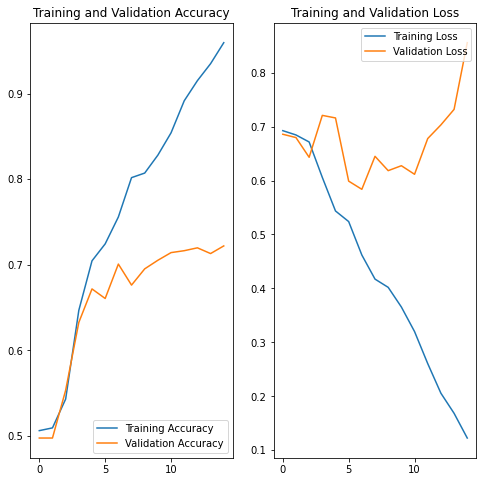

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 过度拟合
 在上面的图中，训练精度随时间呈线性增长，而验证精度在训练过程中停滞在70％左右。同样，训练和验证准确性之间的准确性差异也很明显，这是过度拟合的标志。

 当训练样本数量很少时，模型有时会从训练样本的噪音或不必要的细节中学习，以至于对模型在新样本上的性能产生负面影响。这种现象称为过拟合。这意味着该模型很难推广到新的数据集。

 在训练过程中，有多种方法可以解决过拟合的问题。在本教程中，您将使用数据扩充并将遗漏添加到我们的模型中。

## 数据增加
当培训实例数量很少时，过度拟合通常会发生。解决此问题的一种方法是扩充数据集，使其具有足够数量的训练示例。数据增强采用通过使用产生真实感图像的随机变换增强样本来从现有训练样本生成更多训练数据的方法。目标是模型在训练期间永远不会看到两次完全相同的图片。这有助于使模型暴露于数据的更多方面，并且可以更好地进行概括。

tf.keras使用ImageDataGenerator类来实现这一点。将不同的转换传递给数据集，它将在训练过程中加以应用。

扩充和可视化数据
首先将随机水平翻转增强应用于数据集，然后查看变换后各个图像的外观。

### 应用水平翻转
通过horizontal_flip作为参数传递给ImageDataGenerator类，并将其设置True到应用此增强。

In [39]:
image_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, horizontal_flip=True)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 2000 images belonging to 2 classes.


In [40]:
# 从训练示例中获取一个样本图像，并将其重复五次，以便将增强应用于同一图像五次。

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

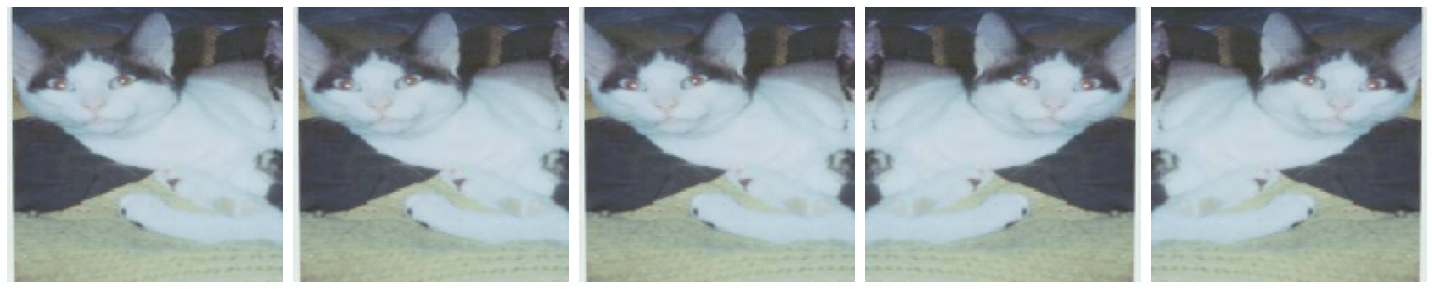

In [41]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)


## 随机旋转图像
让我们看一下另一种称为旋转的增强，然后将45度旋转随机应用于训练示例。

In [43]:
image_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=45)
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


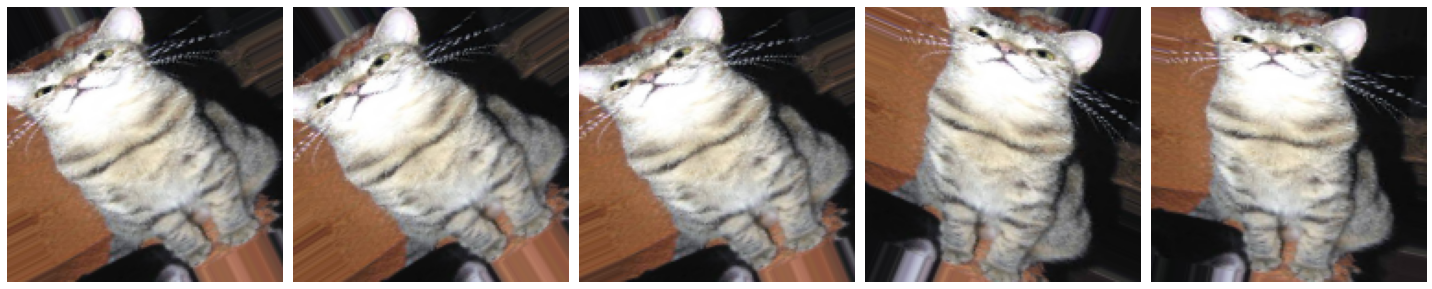

In [44]:
plotImages(augmented_images)


## 应用放大增强
将缩放增强应用于数据集以将图像随机缩放到50％。

In [46]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, zoom_range=0.5) 
train_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH))

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


In [ ]:
plotImages(augmented_images)

# 放在一起
## 应用所有以前的扩充。在这里，您对训练图像应用了重新缩放，45度旋转，宽度偏移，高度偏移，水平翻转和缩放增强。

In [48]:
image_gen_train = keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


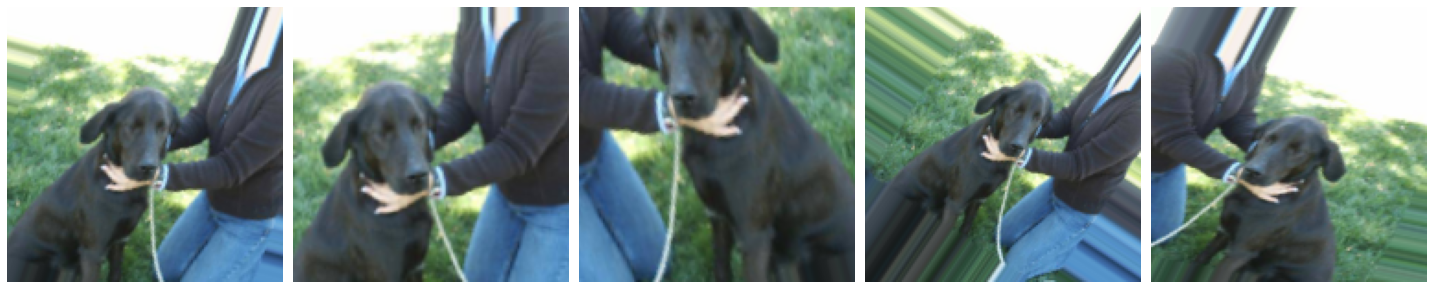

In [49]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## 创建验证数据生成器
通常，仅将数据扩充应用于训练示例。在这种情况下，仅重新缩放验证图像，然后使用将它们转换为批次ImageDataGenerator。

In [52]:
image_gen_val = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=valid_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


## dropout
减少过度拟合的另一种技术是将dropout引入网络。这是一种正则化形式，它迫使网络中的权重仅取较小的值，这使得权重值的分配更加规则，并且网络可以减少在小的训练样本上的过度拟合。辍学是本教程中使用的正则化技术之一

当您在图层上应用滤除时，它会在训练过程中从所应用的图层中随机滤除（设置为零）数量的输出单位。辍学采用分数形式作为其输入值，形式为0.1、0.2、0.4等。这意味着从所施加的层中随机退出输出单元的10％，20％或40％。

将0.1辍学应用于某个图层时，它会在每个训练时期随机杀死10％的输出单位。

使用此新的辍学功能创建网络体系结构，并将其应用于不同的卷积和完全连接的层。

## 使用dropout创建新的网络
在这里，您将删除应用于第一个和最后一个最大池层。在每个训练时期，应用辍学将随机将20％的神经元设置为零。这有助于避免过度拟合训练数据集。

In [54]:
#实现多GPU分布式
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model_new = keras.models.Sequential([
        keras.layers.Conv2D(16, 3, padding='same', activation='relu', 
               input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(0.2),
        keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1)
    ])
    model_new.compile(optimizer='adam',
                      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                      metrics=['accuracy'])

model_new.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device 

In [55]:
history = model.fit_generator(train_data_gen,
                             steps_per_epoch = total_train // batch_size,
                             epochs = epochs,
                             validation_data = valid_data_gen,
                             validation_steps = total_valid // batch_size)

  ...
    to  
  ['...']
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
  ...
    to  
  ['...']
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AutoShardDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RebatchDatase

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
15/15 [==============================] - 15s 979ms/step - loss: 0.6144 - accuracy: 0.6464 - val_loss: 0.5523 - val_accuracy: 0.6763
Epoch 5/15
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op

Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
15/15 [==============================] - 15s 987ms/step - loss: 0.5691 - accuracy: 0.6886 - val_loss: 0.5551 - val_accuracy: 0.7176
Epoch 10/15
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
14/15 [====

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:2
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:3
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:3
14/15 [===========================>..] - ETA: 0s - loss: 0.5857 - accuracy: 0.6594Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/de

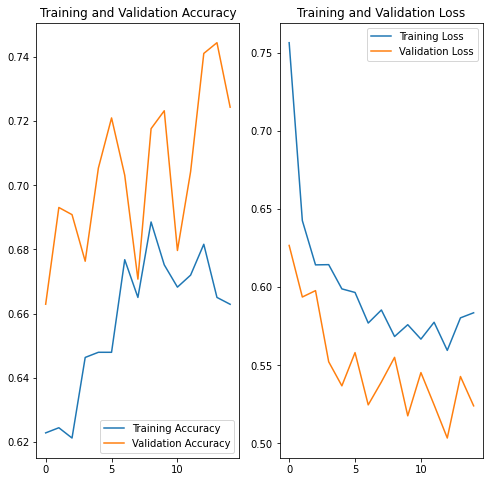

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()